## 1. Introduction

### 1.1 Version note

- version 1: deberta regression without k-fold
- version 2: deberta regression with 10-fold; train:4Knooverlap  

### 1.2 Results record

- version 1: cv:0.834	lb:0.797
- Version 2: cv:0.805   lb:0.799

## 2. Imports and Config

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '2'
import warnings
warnings.simplefilter('ignore')

In [2]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoConfig
from transformers import TrainingArguments, Trainer
from transformers import DataCollatorWithPadding
from datasets import Dataset
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import cohen_kappa_score
from tokenizers import AddedToken
import torch
from transformers import DebertaV2Tokenizer, DebertaV2ForSequenceClassification, DebertaV2Config
import torch.nn as nn
from transformers.modeling_outputs import SequenceClassifierOutputWithPast

2024-05-05 15:59:47.941214: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-05 15:59:48.158852: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-05 15:59:48.893137: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-05-05 15:59:48.893290: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or 

In [3]:
USE_REGRESSION = True

VER=5

LOAD_FROM = None

COMPUTE_CV = True

In [4]:
class PATHS:
    train_path = '../dataset/4k_nooverlap.csv' 
    # train_path = '../dataset//13k_overlap.csv'
    test_path = '../dataset/test.csv'
    submission_path = '../dataset/sample_submission.csv'
    model_dir = '/ai/users/bst/competition/model/microsoft/'
    model_name = 'deberta-v3-large'
    model_path = model_dir + model_name
    output_dir = f'/ai/users/bst/competition/output_v{VER}'

In [5]:
class CFG:
    n_splits = 10
    seed = 42
    max_length = 1024
    lr = 1e-5
    train_batch_size = 1
    eval_batch_size = 1
    gradient_accumulation_steps = 4
    train_epochs = 3
    weight_decay = 0.01
    warmup_ratio = 0.05
    num_labels = 6

In [6]:
def seed_everything(seed):
    import random, os
    import numpy as np
    import torch
    
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    
# seed_everything(seed=CFG.seed)

## 3. Data Loading and Preprocessing

### 3.1 Data Tokenization

In [7]:
class Tokenize(object):
    def __init__(self, train, valid, tokenizer):
        self.tokenizer = tokenizer
        self.train = train
        self.valid = valid
        
    def get_dataset(self, df):
        ds = Dataset.from_dict({
                'essay_id': [e for e in df['essay_id']],
                'full_text': [ft for ft in df['full_text']],
                'label': [s for s in df['label']],
            })
        return ds
        
    def tokenize_function(self, example):
        tokenized_inputs = self.tokenizer(
            example['full_text'], truncation=True, max_length=CFG.max_length
        )
        return tokenized_inputs
    
    def __call__(self):
        train_ds = self.get_dataset(self.train)
        valid_ds = self.get_dataset(self.valid)
        
        tokenized_train = train_ds.map(
            self.tokenize_function, batched=True
        )
        tokenized_valid = valid_ds.map(
            self.tokenize_function, batched=True
        )
        
        return tokenized_train, tokenized_valid, self.tokenizer

### 3.2 Compute Metrics

In [8]:
# 如果是回归任务，需要修改compute_metrics_for_regression函数
def compute_metrics_for_regression(eval_pred):
    
    predictions, labels = eval_pred
    qwk = cohen_kappa_score(labels, predictions.clip(0,5).round(0), weights='quadratic')
    results = {
        'qwk': qwk
    }
    return results

# 如果是分类任务，需要修改compute_metrics_for_classification函数
def compute_metrics_for_classification(eval_pred):
    
    predictions, labels = eval_pred
    qwk = cohen_kappa_score(labels, predictions.argmax(-1), weights='quadratic')
    results = {
        'qwk': qwk
    }
    return results

### 3.3 Load Data and Set Fold

In [9]:
data = pd.read_csv(PATHS.train_path).sample(100, random_state=CFG.seed).reset_index(drop=True)
data['label'] = data['score'].apply(lambda x: x-1)
if USE_REGRESSION: 
    data["label"] = data["label"].astype('float32') 
else: 
    data["label"] = data["label"].astype('int32') 

skf = StratifiedKFold(n_splits=CFG.n_splits, shuffle=True, random_state=CFG.seed)
for i, (_, val_index) in enumerate(skf.split(data, data["score"])):
    data.loc[val_index, "fold"] = i
data.head()

,essay_id,full_text,score,label,fold
0,de27b5d,"In the passage the author tells how Venus is ""...",3,2.0,9.0
1,2c64ebc,Driverless cars should begin to be developed b...,4,3.0,3.0
2,b655bf5,The future is almost here. But\n\nit is not go...,4,3.0,2.0
3,d59e18f,Driverless cars would be a huge problem honest...,2,1.0,0.0
4,139293a,Wow! Can you imagine driving a car that you do...,4,3.0,0.0


## 4. Training Loop

### Model define

In [10]:
def get_last_hidden_state(backbone_outputs):
    last_hidden_state = backbone_outputs[0]
    return last_hidden_state


def get_all_hidden_states(backbone_outputs):
    all_hidden_states = torch.stack(backbone_outputs[1])
    return all_hidden_states


def get_input_ids(inputs):
    return inputs["input_ids"]


def get_attention_mask(inputs):
    return inputs["attention_mask"]

In [11]:
class MeanPooling(nn.Module):
    def __init__(self):
        super(MeanPooling, self).__init__()
        self.output_dim = AutoConfig.from_pretrained("/kaggle/input/deberta-v3-large").hidden_size

    def forward(self, inputs, backbone_outputs):
        attention_mask = get_attention_mask(inputs)
        last_hidden_state = get_last_hidden_state(backbone_outputs)

        input_mask_expanded = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
        sum_embeddings = torch.sum(last_hidden_state * input_mask_expanded, 1)
        sum_mask = input_mask_expanded.sum(1)
        sum_mask = torch.clamp(sum_mask, min=1e-9)
        mean_embeddings = sum_embeddings / sum_mask
        return mean_embeddings

In [12]:
class CustomModel(nn.Module):
    def __init__(self, model_name, num_labels):
        super(CustomModel, self).__init__()
        self.config = DebertaV2Config.from_pretrained(model_name)
        self.config.num_labels = num_labels
        self.model = DebertaV2ForSequenceClassification.from_pretrained(model_name, config=self.config)
        self.pooling = MeanPooling()
        self.liner = nn.Linear(self.pooling.output_dim, num_labels)
    
    def forward(self, inputs, labels=None):
        outputs = self.model(**inputs)
        print(outputs)
        backbone_outputs = outputs[0]
        mean_pooling = self.pooling(inputs, backbone_outputs)
        logits = self.liner(mean_pooling)
        loss = None
        if labels is not None:
            if self.config.num_labels == 1:
                loss_fct = nn.MSELoss()
                loss = loss_fct(logits.view(-1).float(), labels.view(-1).float())
            else:
                loss_fct = nn.CrossEntropyLoss()
                loss = loss_fct(logits.view(-1, self.config.num_labels), labels.view(-1))
        return SequenceClassifierOutputWithPast(
            loss=loss,
            logits=logits,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
        )
        

### 4.1 Set Training Args

In [13]:
# training_args = TrainingArguments(
#     output_dir=PATHS.output_dir,
#     fp16=True,
#     learning_rate=CFG.lr,
#     per_device_train_batch_size=CFG.train_batch_size,
#     per_device_eval_batch_size=CFG.eval_batch_size,
#     gradient_accumulation_steps=CFG.gradient_accumulation_steps,
#     num_train_epochs=CFG.train_epochs,
#     weight_decay=CFG.weight_decay,
#     logging_steps=200,
#     evaluation_strategy='steps',
#     metric_for_best_model='qwk',
#     greater_is_better=True,
#     eval_steps=200,
#     save_strategy="steps",
#     save_steps=200,
#     save_total_limit=5,
#     load_best_model_at_end=True,
#     report_to='none',
#     warmup_ratio=CFG.warmup_ratio,
#     lr_scheduler_type='linear', # "cosine" or "linear" or "constant"
#     optim='adamw_torch',
#     logging_first_step=True,
#     save_only_model=True,
# )

### 4.2 K Fold Training

Map: 100%|██████████| 10/10 [00:00<00:00, 732.32 examples/s]
Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at /ai/users/bst/competition/model/microsoft/deberta-v3-large and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Detected kernel version 4.15.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Step,Training Loss,Validation Loss,Qwk
20,4.239500,1.610496,0.000000
40,0.759900,0.458609,0.411765
60,0.687700,0.432449,0.636364


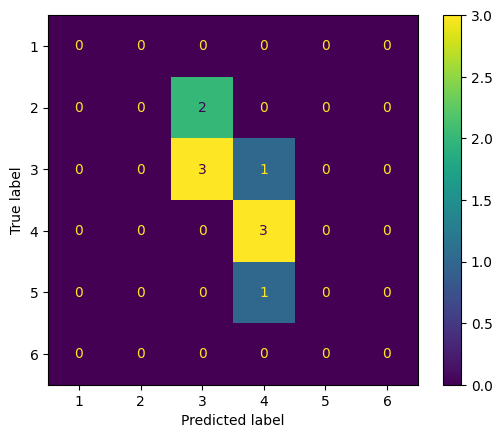

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Map: 100%|██████████| 10/10 [00:00<00:00, 548.15 examples/s]
Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at /ai/users/bst/competition/model/microsoft/deberta-v3-large and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Detected kernel version 4.15.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Step,Training Loss,Validation Loss,Qwk
20,4.638100,2.366137,0.000000
40,0.983700,0.680851,0.000000
60,0.505700,0.532659,0.489796


In [14]:
if COMPUTE_CV:
    for fold in range(len(data['fold'].unique())):
        training_args = TrainingArguments(
            output_dir=PATHS.output_dir+f'/v{fold}',
            fp16=True,
            learning_rate=CFG.lr,
            per_device_train_batch_size=CFG.train_batch_size,
            per_device_eval_batch_size=CFG.eval_batch_size,
            gradient_accumulation_steps=CFG.gradient_accumulation_steps,
            num_train_epochs=CFG.train_epochs,
            weight_decay=CFG.weight_decay,
            logging_steps=20,
            evaluation_strategy='steps',
            metric_for_best_model='qwk',
            greater_is_better=True,
            eval_steps=20,
            save_strategy="steps",
            save_steps=20,
            save_total_limit=5,
            load_best_model_at_end=True,
            report_to='none',
            warmup_ratio=CFG.warmup_ratio,
            lr_scheduler_type='linear', # "cosine" or "linear" or "constant"
            optim='adamw_torch',
            logging_first_step=True,
            save_only_model=True,
        )

        # GET TRAIN AND VALID DATA
        train = data[data['fold'] != fold]
        valid = data[data['fold'] == fold].copy()

        # ADD NEW TOKENS for ("\n") new paragraph and (" "*2) double space 
        tokenizer = AutoTokenizer.from_pretrained(PATHS.model_path)
        tokenizer.add_tokens([AddedToken("\n", normalized=False)])
        tokenizer.add_tokens([AddedToken(" "*2, normalized=False)])
        tokenize = Tokenize(train, valid, tokenizer)
        tokenized_train, tokenized_valid, _ = tokenize()

        # REMOVE DROPOUT FROM REGRESSION
        config = AutoConfig.from_pretrained(PATHS.model_path)
        if USE_REGRESSION:
            config.attention_probs_dropout_prob = 0.0 
            config.hidden_dropout_prob = 0.0 
            config.num_labels = 1 
        else: config.num_labels = CFG.num_labels 

        if LOAD_FROM:
            model = AutoModelForSequenceClassification.from_pretrained( f'/ai/users/bst/competition/outputs/{PATHS.model_name}_AES2_fold_{fold}_v{VER}')
        else:
            model = AutoModelForSequenceClassification.from_pretrained(PATHS.model_path, config=config)
            model.resize_token_embeddings(len(tokenizer))

        # TRAIN WITH TRAINER
        data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
        if USE_REGRESSION: compute_metrics = compute_metrics_for_regression
        else: compute_metrics = compute_metrics_for_classification
        trainer = Trainer( 
            model=model,
            args=training_args,
            train_dataset=tokenized_train,
            eval_dataset=tokenized_valid,
            data_collator=data_collator,
            tokenizer=tokenizer,
            compute_metrics=compute_metrics
        )
        if LOAD_FROM is None:
                trainer.train()

        # PLOT CONFUSION MATRIX
        y_true = valid['score'].values
        predictions0 = trainer.predict(tokenized_valid).predictions
        if USE_REGRESSION: 
            predictions = predictions0.round(0) + 1
        else: 
            predictions = predictions0.argmax(axis=1) + 1 
        cm = confusion_matrix(y_true, predictions, labels=[x for x in range(1,7)])
        draw_cm = ConfusionMatrixDisplay(confusion_matrix=cm,
                                      display_labels=[x for x in range(1,7)])
        draw_cm.plot()
        plt.show()

        # SAVE FOLD MODEL AND TOKENIZER
        if LOAD_FROM is None:
            trainer.save_model(f'/ai/users/bst/competition/outputs/{PATHS.model_name}_AES2_fold_{fold}_v{VER}')
            tokenizer.save_pretrained(f'/ai/users/bst/competition/outputs/{PATHS.model_name}_AES2_fold_{fold}_v{VER}')

        # SAVE OOF PREDICTIONS
        if USE_REGRESSION: 
            valid['pred'] = predictions0 + 1 
        else:
            COLS = [f'p{x}' for x in range(CFG.num_labels)] 
            valid[COLS] = predictions0 
        valid.to_csv(f'outputs/valid_df_fold_{fold}_v{VER}.csv', index=False)

## 5. Evaluation

### 5.1 Overall CV Score

In [ ]:
if COMPUTE_CV:
    dfs = []
    for k in range(CFG.n_splits):
        dfs.append( pd.read_csv(f'outputs/valid_df_fold_{k}_v{VER}.csv') )
        os.system(f'rm outputs/valid_df_fold_{k}_v{VER}.csv')
    dfs = pd.concat(dfs)
    dfs.to_csv(f'outputs/valid_df_v{VER}.csv',index=False)
    print('Valid OOF shape:', dfs.shape )
    display( dfs.head() )

Valid OOF shape: (4436, 6)


,essay_id,full_text,score,label,fold,pred
0,00fca9b,The authors sugestion that studying venus is a...,3,2.0,0.0,2.178396
1,012f8f0,In this story the author suggests that studyin...,3,2.0,0.0,2.893716
2,0293f31,The Facial Action Coding System is a great ach...,3,2.0,0.0,4.213805
3,0499982,My position on driverless cars is that I am a ...,3,2.0,0.0,3.150983
4,04af97d,Driverless should not be used under any condit...,4,3.0,0.0,4.079288


In [ ]:
if COMPUTE_CV:
    if USE_REGRESSION:
        m = cohen_kappa_score(dfs.score.values, dfs.pred.values.clip(1,6).round(0), weights='quadratic')
    else:
        m = cohen_kappa_score(dfs.score.values, dfs.iloc[:,-6:].values.argmax(axis=1)+1, weights='quadratic')
    print('Overall QWK CV =',m)

Overall QWK CV = 0.8054719475951295


### 5.2 Infer Test Data

In [ ]:
test = pd.read_csv(PATHS.test_path)
print('Test shape:', test.shape )
test.head()

Test shape: (3, 2)


,essay_id,full_text
0,000d118,Many people have car where they live. The thin...
1,000fe60,I am a scientist at NASA that is discussing th...
2,001ab80,People always wish they had the same technolog...


In [ ]:
all_pred = []
test['label'] = 0.0

for fold in range(CFG.n_splits):
    
    # LOAD TOKENIZER
    if LOAD_FROM:
        tokenizer = AutoTokenizer.from_pretrained(f'/ai/users/bst/competition/outputs/{PATHS.model_name}_AES2_fold_{fold}_v{VER}')
    else:
        tokenizer = AutoTokenizer.from_pretrained(f'/ai/users/bst/competition/outputs/{PATHS.model_name}_AES2_fold_{fold}_v{VER}')
    tokenize = Tokenize(test, test, tokenizer)
    tokenized_test, _, _ = tokenize()

    # LOAD MODEL
    if LOAD_FROM:
        model = AutoModelForSequenceClassification.from_pretrained(f'/ai/users/bst/competition/outputs/{PATHS.model_name}_AES2_fold_{fold}_v{VER}')
    else:
        model = AutoModelForSequenceClassification.from_pretrained(f'/ai/users/bst/competition/outputs/{PATHS.model_name}_AES2_fold_{fold}_v{VER}')
    
    # INFER WITH TRAINER
    data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
    trainer = Trainer( 
        model=model,
        args=training_args,
        train_dataset=tokenized_test,
        data_collator=data_collator,
        tokenizer=tokenizer,
    )

    # SAVE PREDICTIONS
    predictions = trainer.predict(tokenized_test).predictions
    all_pred.append( predictions )

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Map: 100%|██████████| 3/3 [00:00<00:00, 329.04 examples/s]
Detected kernel version 4.15.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Map: 100%|██████████| 3/3 [00:00<00:00, 272.43 examples/s]
Detected kernel version 4.15.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Map: 100%|██████████| 3/3 [00:00<00:00, 292.28 examples/s]
Detected kernel version 4.15.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Map: 100%|██████████| 3/3 [00:00<00:00, 287.87 examples/s]
Detected kernel version 4.15.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Map: 100%|██████████| 3/3 [00:00<00:00, 328.93 examples/s]
Detected kernel version 4.15.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Map: 100%|██████████| 3/3 [00:00<00:00, 290.06 examples/s]
Detected kernel version 4.15.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Map: 100%|██████████| 3/3 [00:00<00:00, 318.03 examples/s]
Detected kernel version 4.15.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Map: 100%|██████████| 3/3 [00:00<00:00, 348.07 examples/s]
Detected kernel version 4.15.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Map: 100%|██████████| 3/3 [00:00<00:00, 306.01 examples/s]
Detected kernel version 4.15.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Map: 100%|██████████| 3/3 [00:00<00:00, 329.58 examples/s]
Detected kernel version 4.15.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


In [ ]:
preds = np.mean(all_pred, axis=0)
print('Predictions shape:',preds.shape)

Predictions shape: (3,)


### 5.3 Create Submission CSV

In [ ]:
sub = pd.read_csv(PATHS.sub_path)
if USE_REGRESSION: sub["score"] = preds.clip(0,5).round(0)+1
else: sub["score"] = preds.argmax(axis=1)+1
sub.score = sub.score.astype('int32')
sub.to_csv('submission.csv',index=False)
print('Submission shape:', sub.shape )
sub.head()

AttributeError: type object 'PATHS' has no attribute 'sub_path'